In [ ]:
from google.colab import drive

import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import make_grid
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.nn.functional as F

project_seed = 2022
torch.manual_seed(project_seed)

In [ ]:
drive.mount("/content/drive/")

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [ ]:
!curl https://raw.githubusercontent.com/ggonzalesd/3DReconstruction/main/dataset.npy > dataset.npy
!curl https://raw.githubusercontent.com/ggonzalesd/3DReconstruction/main/datasettest.npy > datasettest.npy

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 24.5M  100 24.5M    0     0  82.4M      0 --:--:-- --:--:-- --:--:-- 82.4M
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 6400k  100 6400k    0     0  27.5M      0 --:--:-- --:--:-- --:--:-- 27.5M


In [ ]:
models = np.load("dataset.npy", allow_pickle=True).item()
modelstest = np.load("datasettest.npy", allow_pickle=True).item()

In [ ]:
criterion = nn.BCEWithLogitsLoss()

PATH = "/content/drive/MyDrive/ml-project4/"
PATH_CHECKPOINTS_GEN = PATH + "gen/"
PATH_CHECKPOINTS_DISC = PATH + "disc/"
PATH_IMG = PATH + "img/"

n_epochs = 550
display_step = 7*7
batch_size = 60
lr = 0.00001
#latent_dim = 12
LAMBDA = 100
device = 'cuda'

models_x = [torch.from_numpy(np.array([model])*2 -1).float().to(device) for model in models['train']['x']]
models_y = [torch.from_numpy(np.array([model])*2 -1).float().to(device) for model in models['train']['y']]

modelst_x = [torch.from_numpy(np.array([model])*2 -1).float().to(device) for model in modelstest['test']['x']]
modelst_y = [torch.from_numpy(np.array([model])*2 -1).float().to(device) for model in modelstest['test']['y']]

dataloader = DataLoader(list(zip(models_x, models_y)), batch_size=batch_size, shuffle=True)

In [ ]:
def display_disc(voxel_disc):
    ax = plt.figure().add_subplot(projection='3d')
    ax.voxels((voxel_disc>0.5) * (voxel_disc<0.7) , facecolors='red', alpha=0.1)
    ax.voxels((voxel_disc>=0.7) * (voxel_disc<0.85) , facecolors='yellow', alpha=0.4)
    ax.voxels((voxel_disc>=0.85) , facecolors='lime')
    plt.show()

In [ ]:
def plot_epoch(indata, fakedata, targetdata, save_=False, num=0):
    fig=plt.figure()
    fig.set_size_inches(6, 3)
    ax1=fig.add_subplot(1,2,1,projection='3d')
    ax2=fig.add_subplot(1,2,2,projection='3d')

    ax1.set_title("Input")
    ax2.set_title("Fake")

    ax1.voxels(indata>0, facecolors='yellow')
    ax2.voxels(fakedata>0, facecolors='red')
    if save_:
        plt.savefig(PATH_IMG + f"out_{num}.png")
    else:
        plt.show()

In [ ]:
def downsample(inchan, outchan, batch=True, kernel_size=4, stride=1):
    out = nn.Sequential()
    out.append(
        nn.Conv3d(
            inchan,
            outchan,
            kernel_size=kernel_size,
            stride=stride,
            bias=not batch
        )
    )
    if batch:
        out.append(nn.BatchNorm3d(outchan))
    out.append(nn.LeakyReLU(negative_slope=0.02))
    return out

In [ ]:
def upsample(inchan, outchan, dropout=False, kernel_size=4, stride=1):
    out = nn.Sequential()
    out.append(
        nn.ConvTranspose3d(
            inchan,
            outchan,
            kernel_size=kernel_size,
            stride=stride,
            bias=False
        )
    )
    out.append(nn.BatchNorm3d(outchan))
    if dropout:
        out.append(nn.Dropout3d(0.5))
    out.append(nn.ReLU())
    return out

In [ ]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        ff = 10

        self.d1 = downsample(1, ff, batch=False)                     # 16, 29, 29, 29
        self.d2 = downsample(ff, 2*ff)                               # 32, 26, 26, 26
        self.d3 = downsample(2*ff, 4*ff, stride=2)                   # 64, 12, 12, 12
        self.d4 = downsample(4*ff, 4*ff, stride=2)                   # 64,  5,  5,  5
        self.d5 = downsample(4*ff, 4*ff, stride=2, batch=False)       # 64,  1,  1,  1

        self.u1 = upsample(4*ff, 4*ff, dropout=False, kernel_size=5) # 64,  5,  5,  5
        self.u2 = upsample(8*ff, 4*ff, dropout=False, stride=2)      # 64, 12, 12, 12
        self.u3 = upsample(8*ff, 2*ff, stride=2)                     # 64, 26, 26, 26
        self.u4 = upsample(4*ff, ff)                                  # 16, 29, 29, 29

        self.out = nn.ConvTranspose3d(2*ff, 1, kernel_size=4)
        self.act = nn.Tanh()
    
    def forward(self, x):
        s = []

        x = self.d1(x)
        s.append(x)
        x = self.d2(x)
        s.append(x)
        x = self.d3(x)
        s.append(x)
        x = self.d4(x)
        s.append(x)
        x = self.d5(x)

        x = self.u1(x)
        x = torch.cat((x, s[-1]), dim=1)
        x = self.u2(x)
        x = torch.cat((x, s[-2]), dim=1)
        x = self.u3(x)
        x = torch.cat((x, s[-3]), dim=1)
        x = self.u4(x)
        x = torch.cat((x, s[-4]), dim=1)

        return self.act(self.out(x))

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.d1 = downsample(2, 16, batch=False)
        self.d2 = downsample(16, 32)
        self.d3 = downsample(32, 64, stride=2)
        self.d4 = downsample(64, 64, stride=2)
        self.d5 = downsample(64, 64, stride=2)

        self.out = nn.ConvTranspose3d(64, 1, kernel_size=4)
        self.act = nn.Sigmoid()

    def forward(self, x, y):
        x = torch.cat((x, y), dim=1)

        x = self.d1(x)
        x = self.d2(x)
        x = self.d3(x)
        x = self.d4(x)
        x = self.d5(x)

        return self.act(self.out(x))

In [ ]:
def get_disc_loss(criterion, disc_real_out, disc_fake_out):
    disc_real_loss = criterion(disc_real_out, torch.ones_like(disc_real_out))
    disc_fake_loss = criterion(disc_fake_out, torch.zeros_like(disc_fake_out))
    
    return  (disc_fake_loss + disc_real_loss) / 2

In [ ]:
def get_gen_loss(criterion, disc_real_out, disc_fake_out, target, fake, lambda_):
    disc_fake_loss = criterion(disc_fake_out, torch.ones_like(disc_fake_out))
    target_loss = torch.mean(torch.abs(target - fake))
    
    return  disc_fake_loss + lambda_*target_loss

In [ ]:
# Load Model from Drive
gen = Generator().to(device)
disc = Discriminator().to(device)

gen.load_state_dict(torch.load(PATH + "gen.pth"))
disc.load_state_dict(torch.load(PATH + "disc.pth"))

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
# Create a new Model
gen = Generator().to(device)
disc = Discriminator().to(device)

gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

In [ ]:
cur_step = 0

In [ ]:
lepoch = 0

In [ ]:
mean_generator_loss = 0
mean_discriminator_loss = 0
for epoch in range(n_epochs):
    if epoch % 5 == 0:
        torch.save(disc.state_dict(), PATH_CHECKPOINTS_DISC+f'/disc_{epoch}.pth')
        torch.save(gen.state_dict(), PATH_CHECKPOINTS_GEN+f'/gen_{epoch}.pth')
    for inputdata, targetdata in tqdm(dataloader):
        disc_opt.zero_grad()
        fake = gen(inputdata)
        o_fake = disc(inputdata, fake)
        o_real = disc(inputdata, targetdata)
        disc_loss = get_disc_loss(criterion, o_real, o_fake)
        disc_loss.backward(retain_graph=True)
        disc_opt.step()

        gen_opt.zero_grad()
        fake = gen(inputdata)
        o_fake = disc(inputdata, fake)
        o_real = disc(inputdata, targetdata)
        gen_loss = get_gen_loss(criterion, o_real, o_fake, targetdata, fake, LAMBDA)
        gen_loss.backward()
        gen_opt.step()
        
        mean_discriminator_loss += disc_loss.item() / display_step
        mean_generator_loss += gen_loss.item() / display_step

        if  (cur_step) % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            plot_epoch(inputdata[0][0], fake[0][0], targetdata[0][0], True, cur_step)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1

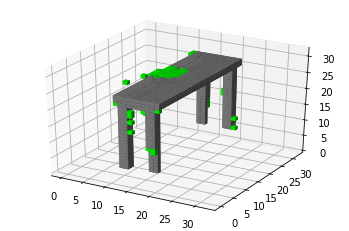

In [ ]:
x1 = torch.stack([models_x[3],])
x = gen(x1)

x1 = x1[0][0].detach().cpu().numpy() > 0
x = x[0][0].detach().cpu().numpy() > 0

ax = plt.figure().add_subplot(projection='3d')
ax.voxels(x1 , facecolors='gray')
ax.voxels(x&~x1 , facecolors='lime')
plt.show()

In [ ]:
torch.save(disc.state_dict(), PATH + 'disc.pth')
torch.save(gen.state_dict(), PATH + 'gen.pth')